In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
%cd ..
%ls

/home/mahdigilany/offline_codes/codes/ts_snr
configs/  main.py     OLD/       requirements.txt  slurm_logs/  wandb/
logs/     notebooks/  README.md  scripts/          src/


## Left over

In [267]:
from src.data.registry.data_registry import create_dataset, create_noisy_dataset
from darts.timeseries import concatenate
train_ts, val_ts, test_ts, scaler = create_dataset('air_passengers')
train_noisy_ts, val_noisy_ts, test_noisy_ts, scaler_noisy = create_noisy_dataset('air_passengers', noise_std=50)
series_ts = concatenate([train_ts, val_ts])._xa.values.reshape(-1)
series_noisy_ts = concatenate([train_noisy_ts, val_noisy_ts])._xa.values.reshape(-1)


(29, 2)


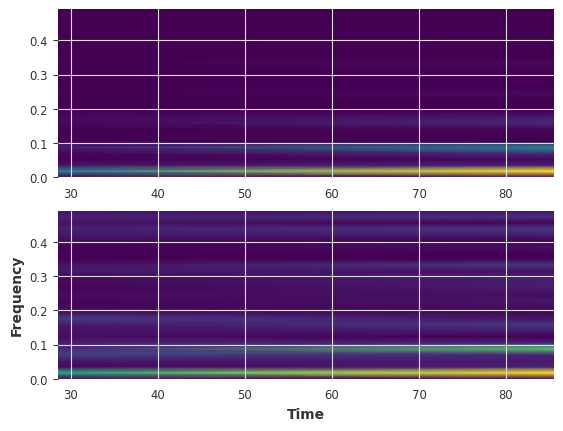

In [268]:
from scipy.signal import periodogram, spectrogram
nperseg = len(series_ts)//2
noverlap = 0
f, t, Sxx = spectrogram(series_ts, nperseg=nperseg, noverlap=noverlap)
f_noisy, t_noisy, Sxx_noisy = spectrogram(series_noisy_ts, nperseg=nperseg, noverlap=noverlap)
print(Sxx.shape)

# n = 3 # to remove noise power
# Sxx_noisy[n:,:] = Sxx[n:,:]

fig, (ax1, ax2) = plt.subplots(2,1,)
ax1.pcolormesh(t, f, Sxx, shading='gouraud')
ax2.pcolormesh(t_noisy, f_noisy, Sxx_noisy, shading='gouraud')
# plt.ylim(0, .1)
plt.ylabel('Frequency')
plt.xlabel('Time')
plt.show()

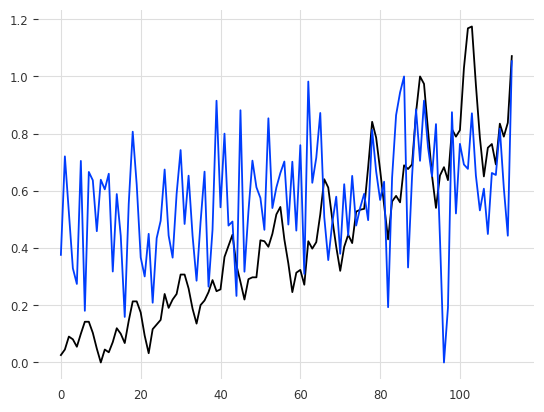

In [186]:
plt.plot(range(len(series_ts)), series_ts)
plt.plot(range(len(series_noisy_ts)), series_noisy_ts)

In [189]:
from scipy.signal import lombscargle
nout = 1000000
w = np.linspace(0.01, 10, nout)
pgram = lombscargle(range(len(series_ts)), series_ts, w, normalize=True)
pgram_noisy = lombscargle(range(len(series_noisy_ts)), series_noisy_ts, w, normalize=True)

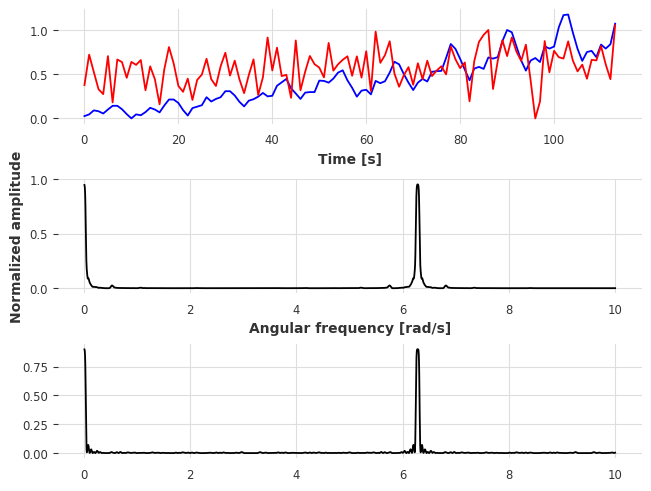

In [191]:
fig, (ax_t, ax_w, ax_w_noisy) = plt.subplots(3, 1, constrained_layout=True)
ax_t.plot(range(len(series_ts)), series_ts, 'b-')
ax_t.set_xlabel('Time [s]')
ax_t.plot(range(len(series_noisy_ts)), series_noisy_ts, 'r-')
ax_w.plot(w, pgram)
ax_w.set_xlabel('Angular frequency [rad/s]')
ax_w.set_ylabel('Normalized amplitude')
ax_w_noisy.plot(w, pgram_noisy)
plt.show()

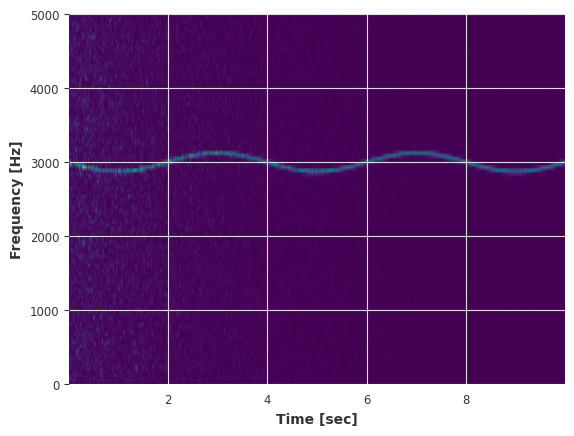

In [45]:
import numpy as np
from scipy import signal
from scipy.fft import fftshift
import matplotlib.pyplot as plt
rng = np.random.default_rng()
fs = 10e3
N = 1e5
amp = 2 * np.sqrt(2)
noise_power = 0.01 * fs / 2
time = np.arange(N) / float(fs)
mod = 500*np.cos(2*np.pi*0.25*time)
carrier = amp * np.sin(2*np.pi*3e3*time + mod)
noise = rng.normal(scale=np.sqrt(noise_power), size=time.shape)
noise *= np.exp(-time/5)
x = carrier + noise

f, t, Sxx = signal.spectrogram(x, fs)
x.shape
plt.pcolormesh(t, f, Sxx, shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [280]:
from pyts.decomposition import SingularSpectrumAnalysis

X = series_noisy_ts.reshape(1, -1)
# We decompose the time series into three subseries
window_size = 24
groups = [np.arange(i, i + 5) for i in range(0, 11, 5)]

# Singular Spectrum Analysis
ssa = SingularSpectrumAnalysis(window_size=window_size, groups=None)
X_ssa = ssa.fit_transform(X)


X_ssa.shape

(24, 114)

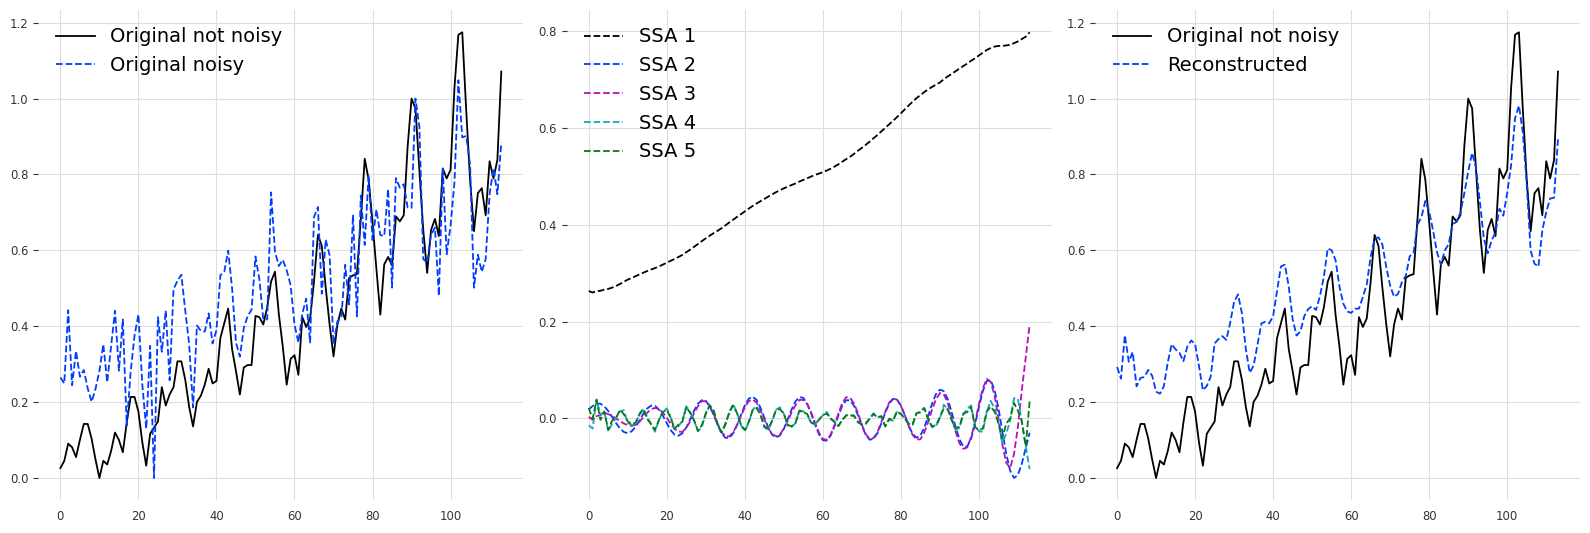

In [285]:
n_reconstructed_features = 5
recon_X = sum([X_ssa[i] for i  in range(n_reconstructed_features)])

# Show the results for the first time series and its subseries
plt.figure(figsize=(16, 6))

ax1 = plt.subplot(131)
ax1.plot(series_ts, '-', label='Original not noisy')
ax1.plot(X[0], '--', label='Original noisy')
ax1.legend(loc='best', fontsize=14)

ax2 = plt.subplot(132)
for i in range(n_reconstructed_features):
    ax2.plot(X_ssa[i], '--', label=f'SSA {i + 1}')
ax2.legend(loc='best', fontsize=14)

ax3 = plt.subplot(133)
ax3.plot(series_ts, '-', label='Original not noisy')
ax3.plot(recon_X, '--', label='Reconstructed')
ax3.legend(loc='best', fontsize=14)

plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()

## Orthogonal Matching Pursuit

In [7]:
from src.data.registry.data_registry import create_dataset, create_noisy_dataset
from darts.timeseries import concatenate
data_series = create_dataset('air_passengers')
noisy_data_series = create_noisy_dataset('air_passengers', noise_std=0.1)
train_ts, val_ts, test_ts, scaler = data_series.train_series, data_series.val_series, data_series.test_series, data_series.scaler
train_noisy_ts, val_noisy_ts, test_noisy_ts, scaler_noisy = noisy_data_series.train_series, noisy_data_series.val_series, noisy_data_series.test_series, noisy_data_series.scaler
series_ts = concatenate([train_ts, val_ts])._xa.values.reshape(-1)
series_noisy_ts = concatenate([train_noisy_ts, val_noisy_ts])._xa.values.reshape(-1)

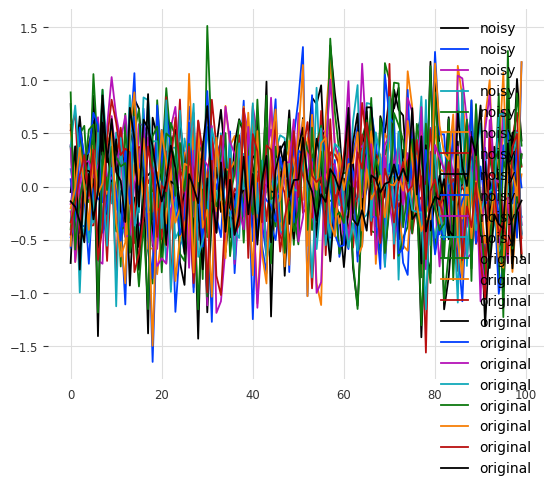

In [107]:
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.linear_model import OrthogonalMatchingPursuitCV
from sklearn.datasets import make_sparse_coded_signal
n_components, n_features = 512, 100
n_nonzero_coefs = 17
y, D, x = make_sparse_coded_signal(
    n_samples=11,
    n_components=n_components,
    n_features=n_features,
    n_nonzero_coefs=n_nonzero_coefs,
    random_state=0,
    data_transposed=True,
)
(idx,) = w.nonzero()
y_noisy = y + 0.2 * np.random.randn(*y.shape)
plt.plot(y_noisy[], label='noisy')
plt.plot(y, label='original')
plt.legend()

In [108]:
y.shape, D.shape, x.shape

((100, 11), (100, 512), (512, 11))

In [102]:
omp = OrthogonalMatchingPursuit(n_nonzero_coefs=n_nonzero_coefs-8)
omp.fit(D, y_noisy)
coef = omp.coef_

In [103]:
coef.shape, n_nonzero_coefs

((512,), 17)

In [104]:
y_hat = np.matmul(D,coef)
np.mean((y_hat - y)**2), np.mean((y_hat - y_noisy)**2), np.mean((y - y_noisy)**2) 

(0.012724907589741152, 0.036046804615048084, 0.03887063732161101)

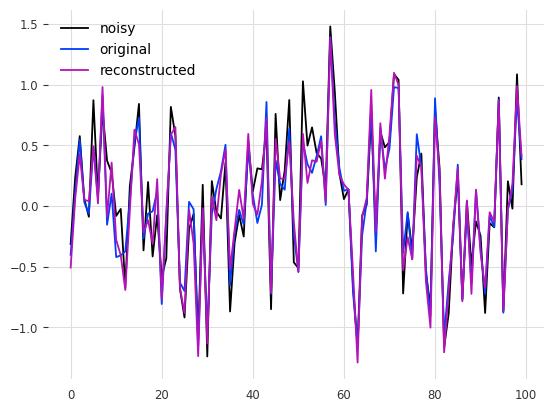

In [105]:
plt.plot(y_noisy, label='noisy')
plt.plot(y, label='original')
plt.plot(y_hat, label='reconstructed')
plt.legend()